# Implementation of Perelson et al.

In this implementation we're going to evaluate the properties of a [dynamical model](http://science.sciencemag.org/content/271/5255/1582).

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import exp

### (1) Reproduce all four panels from Figure 1 shown in Perelson et al. using eq. 6

Since we are not given any empirical data, use the fitted parameters and the appropriate constants to generate the curves shown on these plots. Remember to account for the time delays for each patient.

#### (i) Implement eq. 6 from the paper as a function.

In [3]:
# Answer
def VI(V0, c, t):
    return V0*exp(-c*t)
def VNI(V0,c,t,delta):
    a = c/(c-delta)
    a2 = a*(exp(-delta*t) - exp(-c*t) - delta*t*exp(-c*t))
    return V0*a*a2
def V(V0,c,t,delta):
    return VI(V0,c,t) + VNI(V0,c,t,delta)


#### (ii) Make the plot from this function's values over time.

Note that some constants are given in other papers published by this lab. An estimate of k, the viral infectivity rate, can be found in Wein et al. (J. Theor. Biol. 192:81-98) to be $3.43\times10^{-8}$ mL/(virion•day). Note that you will need to solve ordinary differential equations for $T^*$, $V_I$, and $V_{NI}$ to reproduce the data in Figure 1.

Text(0.5, 1.0, 'Plasma Infectivity Data for Patient 105')

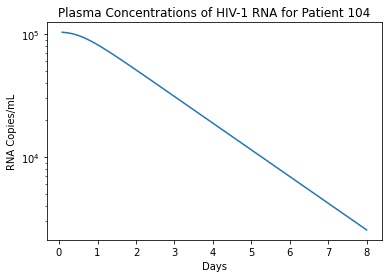

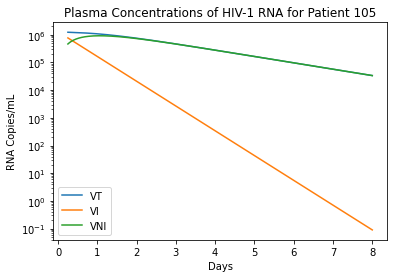

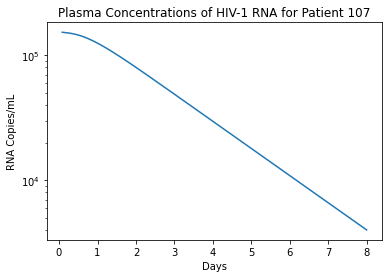

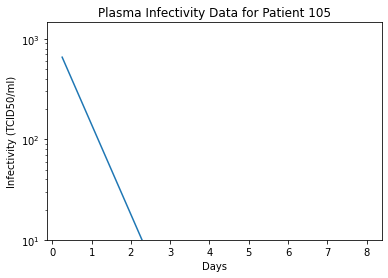

In [4]:
# Answer
# [V0, c, delta, T0]
# T = T0 + T*
P104 = [(52000*2), 3.68, 0.50, 2000]
P105 = [(643000*2), 2.06, 0.53, 11000]
P107 = [(77000*2), 3.09, 0.50, 412000]
tps104_7 = np.linspace(2/24,8,1000)
tps105 = np.linspace(6/24, 8, 1000)
y104 = []
y105 = []
y107 = []
for i in range (1000):
    y104.append(V(P104[0],P104[1],tps104_7[i],P104[2]))
    y105.append(V(P105[0],P105[1],tps105[i],P105[2]))
    y107.append(V(P107[0],P107[1],tps104_7[i],P107[2]))
vi = []
vni = []
for i in range(1000):
    vi.append(VI(P105[0],P105[1],tps105[i]))
    vni.append(VNI(P105[0],P105[1],tps105[i],P105[2]))

plt.figure()
plt.plot(tps104_7,y104)
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")
plt.yscale('log')
plt.title("Plasma Concentrations of HIV-1 RNA for Patient 104")

plt.figure()
plt.plot(tps105,y105, label = "VT")
plt.plot(tps105,vi, label = "VI")
plt.plot(tps105,vni, label = "VNI")
plt.legend()
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")
plt.yscale('log')
plt.title("Plasma Concentrations of HIV-1 RNA for Patient 105")

plt.figure()
plt.plot(tps104_7,y107)
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")
plt.yscale('log')
plt.title("Plasma Concentrations of HIV-1 RNA for Patient 107")

a = 1.1e3
for i in range(len(vi)):
    vi[i] *= a/P105[0]
    
plt.figure()
plt.plot(tps105, vi)
plt.yscale('log')
plt.ylim(bottom=10)
plt.xlabel('Days')
plt.ylabel('Infectivity (TCID50/ml)')
plt.title("Plasma Infectivity Data for Patient 105")

### (2) Can the model of virion production before treatment show stable or unstable oscillations?

Justify your answer.

A system can only display oscillations if there is a complex component in its eigenvalues. To calculate the eigenvalues, the jacobian must be calculated. Since we know the time derivatives of the following:
$$\frac{dT^*}{dt} = kVT - \delta T^* $$
$$\frac{dV}{dt} = N \delta T^* - cV $$
We can calculate the Jacobian by taking the partial derivative of both equations with respect to $T^*$ and $V$, which provides the Jacobian matrix:
$$\mathbf{J} = \begin{bmatrix} - \delta & kT\\ N \delta & -c- \lambda \end{bmatrix}$$
By taking the determinant of the Jacobian matrix, we can get the equation for eigenvalues by setting the determinant to 0:
$$\lambda^2 + (\delta + c) \lambda + \delta c - kTN \delta = 0$$
$$\lambda = \frac{-(\delta + c) \pm \sqrt{( \delta + c)^2 -4( \delta c - kTN \delta)}}{2}$$
In order for $\lambda$ to have a complex component, the expression under the square root must be negative, i.e. $(\delta + c)^2 < 4(\delta c - kTN \delta)$. However, since note 10 states the $c = NkT_{0}$, $T$ is held constant at $T_{0}$ before the treatment is administered, which is the maximum number of uninfected cells. After substituting into the quadratic equation, we can see that $\sqrt{( \delta + c)^2 -4( \delta c - kTN \delta)}$ is always positive, and thus there can never be a complex component in the eigenvalue. As such, the system will not display oscillations.

### (3) Reimplement the model relaxing the assumption about T remaining constant by numerically solving the system of ODEs.

#### i. Define a function that takes each parameter as a vector and outputs the time derivative of each species.

In [5]:
# Answer
#T* is infected, T is Suscpetible ,V is virion, infection rate is k, 
# [T*, VI, VNI]
# T = T0 + T*
def deriv(state, t, k, T0, delta, c, N):
    dTstar_dt = k*state[1]*(state[0]+T0) - delta*state[0]
    dVi_dt = -c*state[1]
    dVni_dt = N*delta*state[0] - c*state[2]
    dy = [dTstar_dt, dVi_dt, dVni_dt]
    return dy

#### ii. Use odeint to solve this system of equations numerically for patient 105.

Hint: For ease later, it may be helpful to make a function here that handles everything but takes in gnu.

Text(0, 0.5, 'RNA Copies/mL')

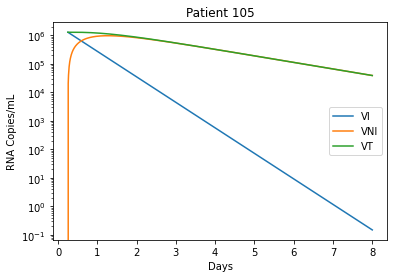

In [7]:
# Answer
from scipy.integrate import odeint
k = 3.43e-8
def odesolve(deriv,t,k,delta,V0,T0,c):
    Tstar = k*V0*T0/delta
    N = c*V0/(delta*Tstar)
    istate = [Tstar, V0, 0]
    y = odeint(deriv, istate, t, args = (k, T0, delta, c, N))
    return y
ode105 = odesolve(deriv, tps105, k, P105[2],P105[0],P105[3],P105[1])
VI105 = ode105[:,1]
VNI105 = ode105[:,2]
VT105 = VI105 + VNI105

plt.figure()
plt.plot(tps105, VI105, label="VI")
plt.plot(tps105, VNI105, label="VNI")
plt.plot(tps105, VT105, label="VT")
plt.legend()
plt.yscale('log')
plt.title("Patient 105")
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")

#### iii. Reproduce the subpanels of Fig. 1 with this updated model. 

Text(0.5, 1.0, 'Plasma Infectivity Data for Patient 105')

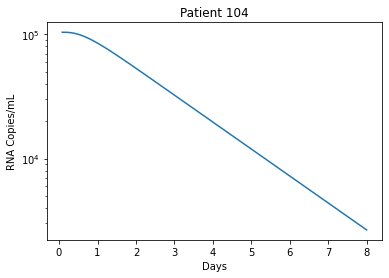

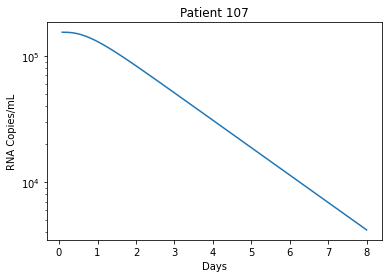

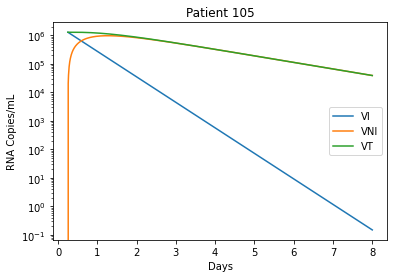

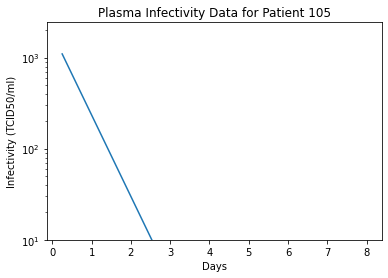

In [6]:
# Answer
ode104 = odesolve(deriv, tps104_7, k, P104[2], P104[0], P104[3], P104[1])
ode107 = odesolve(deriv, tps104_7, k, P107[2], P107[0], P107[3], P107[1])

plt.figure()
plt.plot(tps104_7, (ode104[:,1]+ode104[:,2]))
plt.yscale('log')
plt.title("Patient 104")
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")

plt.figure()
plt.plot(tps104_7, (ode107[:,1]+ode107[:,2]))
plt.yscale('log')
plt.title("Patient 107")
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")

plt.figure()
plt.plot(tps105, VI105, label="VI")
plt.plot(tps105, VNI105, label="VNI")
plt.plot(tps105, VT105, label="VT")
plt.legend()
plt.yscale('log')
plt.title("Patient 105")
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")

a = 1.1e3
VI105a = []
VI105a = VI105*a/P105[0]
plt.figure()
plt.plot(tps105, VI105a)
plt.yscale('log')
plt.ylim(bottom=10)
plt.xlabel('Days')
plt.ylabel('Infectivity (TCID50/ml)')
plt.title("Plasma Infectivity Data for Patient 105")

#### iv. Are the results the same as in (1)?

Show evidence of your conclusion.

Text(0, 0.5, 'RNA Copies/mL')

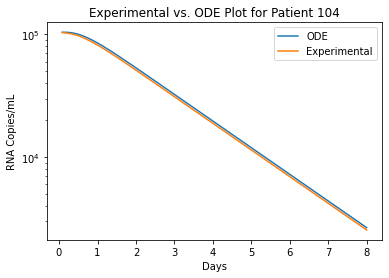

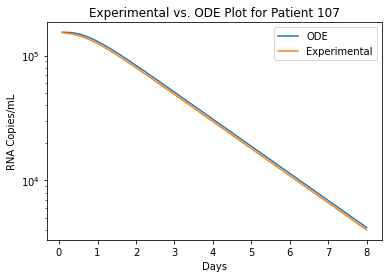

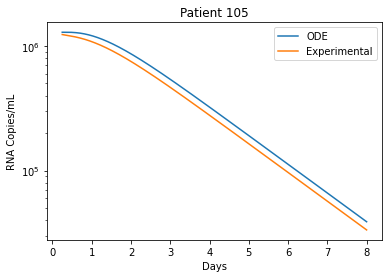

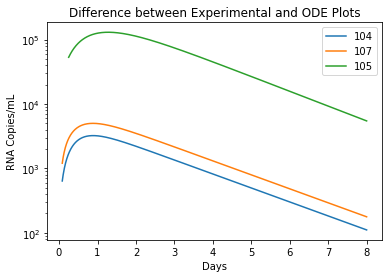

In [7]:
# Answer
plt.figure()
plt.plot(tps104_7, (ode104[:,1]+ode104[:,2]), label = "ODE")
plt.plot(tps104_7, y104, label = "Experimental")
plt.legend()
plt.yscale('log')
plt.title("Experimental vs. ODE Plot for Patient 104")
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")

plt.figure()
plt.plot(tps104_7, (ode107[:,1]+ode107[:,2]), label = "ODE")
plt.plot(tps104_7, y107, label = "Experimental")
plt.legend()
plt.yscale('log')
plt.title("Experimental vs. ODE Plot for Patient 107")
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")

plt.figure()
plt.plot(tps105, VT105, label="ODE")
plt.plot(tps105, y105, label = "Experimental")
plt.legend()
plt.yscale('log')
plt.title("Patient 105")
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")

plt.figure()
plt.plot(tps104_7, ((ode104[:,1]+ode104[:,2])-y104), label = "104")
plt.plot(tps104_7, ((ode107[:,1]+ode107[:,2])-y107), label = "107")
plt.plot(tps105, (VT105-y105), label = "105")
plt.legend()
plt.yscale('log')
plt.title("Difference between Experimental and ODE Plots")
plt.xlabel("Days")
plt.ylabel("RNA Copies/mL")

The results are not the same in 3 as they are in 1, especially seen in the plots where the two lines are clearly not collinear from 0-2 days. However, as the number of days increases, the two lines begin to converge, and the difference between the experimental and ODE lines decreases. As such, we can argue that over long periods of time, the results of the ODE and experimental plots are the same, whereas that is not the case under short time scales (0-2 days). 

### (4) Repeat the work that the authors describe in item 12 of their “References and Notes”.

#### (i) Namely, vary the effectiveness factor of the drug (η=1.0, 0.99, 0.95, and 0.90) and simulate the viral load that would result from the modified differential equations using the parameters c=3.0 days$^{-1}$ and δ=0.5 days$^{-1}$ as described in item 12 and the values of T0, V0, and the time delay provided for patient 105.

Text(0.5, 1.0, 'VTs')

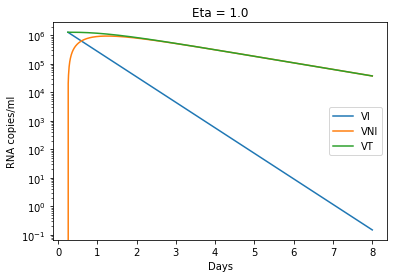

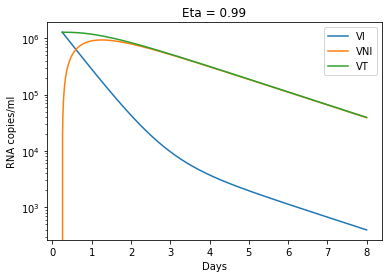

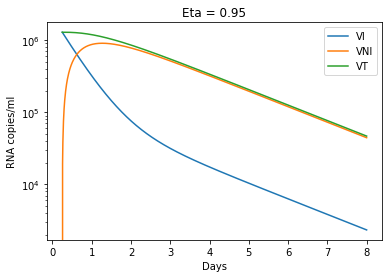

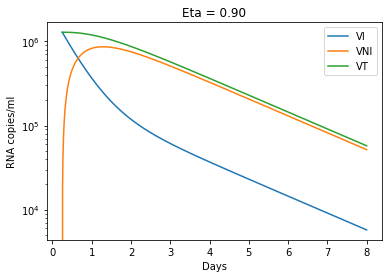

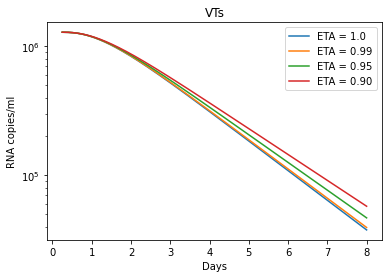

In [9]:
# Answer
P105 = [643000*2, 2.06, 0.53, 11000]
T0 = P105[3]
V0 = P105[0]
c = 3
delta = 0.5
delay = 6/24
tps_wdelay = tps105 + delay

def derive2(state, t, k, T0, delta, c, N, eta):
    dTstar_dt = k*state[1]*(T0-state[0]) - delta*state[0]
    dVi_dt = -c*state[1]+(1-eta)*N*delta*state[0]
    dVni_dt = eta*N*delta*state[0]-c*state[2]
    vals = [dTstar_dt,dVi_dt,dVni_dt]
    return vals

def odesolve2(derive2, t, k, delta, V0, T0, c, eta):
    Tstar = k*V0*T0/delta
    N = c*V0/(delta*Tstar)
    istate = [Tstar, V0, 0]
    y = odeint(derive2, istate, t, args = (k, T0, delta, c, N, eta))
    return y
etas = [1, 0.99, 0.95, 0.9]
y1 = odesolve2(derive2, tps105, k, P105[2], V0, T0, P105[1], etas[0])
y2 = odesolve2(derive2, tps105, k, P105[2], V0, T0, P105[1], etas[1])
y3 = odesolve2(derive2, tps105, k, P105[2], V0, T0, P105[1], etas[2])
y4 = odesolve2(derive2, tps105, k, P105[2], V0, T0, P105[1], etas[3])

VT11 = y1[:,1] + y1[:,2]
plt.figure()
plt.plot(tps105, y1[:,1], label="VI")
plt.plot(tps105, y1[:,2], label="VNI")
plt.plot(tps105, VT11, label="VT")
#plt.plot(tps_wdelay, y1[:,1], label="VI")
#plt.plot(tps_wdelay, y1[:,2], label="VNI")
#plt.plot(tps_wdelay, VT11, label="VT")
plt.yscale('log')
plt.title("Eta = 1.0")
plt.xlabel("Days")
plt.ylabel('RNA copies/ml')
plt.legend()

VT22 = y2[:,1] + y2[:,2]
plt.figure()
plt.plot(tps105, y2[:,1], label="VI")
plt.plot(tps105, y2[:,2], label="VNI")
plt.plot(tps105, VT22, label="VT")
#plt.plot(tps_wdelay, y2[:,1], label="VI")
#plt.plot(tps_wdelay, y2[:,2], label="VNI")
#plt.plot(tps_wdelay, VT22, label="VT")
plt.yscale('log')
plt.title("Eta = 0.99")
plt.xlabel("Days")
plt.ylabel('RNA copies/ml')
plt.legend()

VT33 = y3[:,1] + y3[:,2]
plt.figure()
plt.plot(tps105, y3[:,1], label="VI")
plt.plot(tps105, y3[:,2], label="VNI")
plt.plot(tps105, VT33, label="VT")
#plt.plot(tps_wdelay, y3[:,1], label="VI")
#plt.plot(tps_wdelay, y3[:,2], label="VNI")
#plt.plot(tps_wdelay, VT33, label="VT")
plt.yscale('log')
plt.title("Eta = 0.95")
plt.xlabel("Days")
plt.ylabel('RNA copies/ml')
plt.legend()

VT44 = y4[:,1] + y4[:,2]
plt.figure()
plt.plot(tps105, y4[:,1], label="VI")
plt.plot(tps105, y4[:,2], label="VNI")
plt.plot(tps105, VT44, label="VT")
#plt.plot(tps_wdelay, y4[:,1], label="VI")
#plt.plot(tps_wdelay, y4[:,2], label="VNI")
#plt.plot(tps_wdelay, VT44, label="VT")
plt.yscale('log')
plt.title("Eta = 0.90")
plt.xlabel("Days")
plt.ylabel('RNA copies/ml')
plt.legend()

plt.figure()
plt.plot(tps105, VT11, label = "ETA = 1.0")
plt.plot(tps105, VT22, label = "ETA = 0.99")
plt.plot(tps105, VT33, label = "ETA = 0.95")
plt.plot(tps105, VT44, label = "ETA = 0.90")
#plt.plot(tps_wdelay, VT11, label = "ETA = 1.0")
#plt.plot(tps_wdelay, VT22, label = "ETA = 0.99")
#plt.plot(tps_wdelay, VT33, label = "ETA = 0.95")
#plt.plot(tps_wdelay, VT44, label = "ETA = 0.90")
plt.yscale('log')
plt.legend()
plt.xlabel("Days")
plt.ylabel('RNA copies/ml')
plt.title("VTs")

#### (ii) Then, use the function `scipy.optimize.leastsq` to fit this data to the equation for V(t) given in the paper and find the estimates of c and δ that result. Fit only the portion of the curve after the pharmacokinetic delay. Compare these estimates to the actual values for c and δ and discuss the consequences of an imperfect drug on clearance time estimates.

In [11]:
# Answer
# [T*, VI, VNI]
from scipy.optimize import least_squares
act_c = [3, 3.003, 3.015, 3.028]
act_delta = [0.5, 0.494, 0.47, 0.441]
etas = [1, 0.99, 0.95, 0.9]
c = 3
delta = 0.5
def residuals(vals, derive2, t, k, V0, T0, eta, act_c, act_delta):
    y_pred = odesolve2(derive2, t, k, vals[0], V0, T0, vals[1], eta)
    y_act = odesolve(deriv, t, k, act_delta, V0, T0, act_c)
    return ((y_pred[:,1] + y_pred[:,2]) - (y_act[:,1] + y_act[:,2]))

arr_d, arr_c = np.ones(len(etas)), np.ones(len(etas))
x0 = np.array([0.5, 3])

for i in range (len(etas)):
    ls_sq = least_squares(residuals, x0, args = (derive2, tps105, k, V0, T0, etas[i], c, delta))
    arr_d[i] = ls_sq.x[0]
    arr_c[i] = ls_sq.x[1]

    print("eta:", etas[i])
    print("Least Squares Estimate of Delta:", arr_d[i])
    print("Least Squares Estimate of c:", arr_c[i])
    print("Real Delta:", act_delta[i])
    print("Real C:", act_c[i])

eta: 1
Least Squares Estimate of Delta: 0.5056591545401943
Least Squares Estimate of c: 2.7060196076467196
Real Delta: 0.5
Real C: 3
eta: 0.99
Least Squares Estimate of Delta: 0.5117856856098563
Least Squares Estimate of c: 2.701525972857604
Real Delta: 0.494
Real C: 3.003
eta: 0.95
Least Squares Estimate of Delta: 0.5379782896156694
Least Squares Estimate of c: 2.682647787974943
Real Delta: 0.47
Real C: 3.015
eta: 0.9
Least Squares Estimate of Delta: 0.5750696804563284
Least Squares Estimate of c: 2.6570813912998403
Real Delta: 0.441
Real C: 3.028


These estimates are higher in delta, but lower in c when compared to the real values, which indicates an underestimation of the rate constant of virion clearance. This indicates that a non-perfect drug would lead to an overestimation in the clearance time, as the rate constant of clearance is greater than what we estimate with a non-perfect drug.

#### (iii) Examine the residual plots from your fits to determine whether or not there is a trend in the error associated with fitting these new curves.

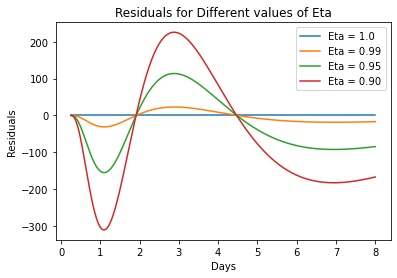

In [10]:
# Answer
eta1 = residuals([arr_d[0],  arr_c[0]], derive2, tps105, k, V0, T0, etas[0], c, delta)
eta99 = residuals([arr_d[1], arr_c[1]], derive2, tps105, k, V0, T0, etas[1], c, delta)
eta95 = residuals([arr_d[2], arr_c[2]], derive2, tps105, k, V0, T0, etas[2], c, delta)
eta90 = residuals([arr_d[3], arr_c[3]], derive2, tps105, k, V0, T0, etas[3], c, delta)

plt.plot(tps105, eta1, label ="Eta = 1.0")
plt.plot(tps105, eta99, label = "Eta = 0.99")
plt.plot(tps105, eta95, label ="Eta = 0.95")
plt.plot(tps105, eta90, label ="Eta = 0.90")
plt.xlabel("Days")
plt.ylabel("Residuals")
plt.title("Residuals for Different values of Eta")
plt.legend()

The residual plots show that as eta moves away from 1, the error associated with fitting these new curves increases. The residual plots also show a damped sinusoidal curve, as the amplitude of the residuals seems to decrease with each maxima/minima when eta is not equal to 1. This indicates that for longer periods of time, the residuals will eventually reach 0 or negligible amounts for eta values that are not equal to 1.

### (5) To determine the TCID50 one should estimate an infectivity coefficient.

To calculate the infectivity coefficient, estimate the ratio of $V_I(t=0)$ to the value of TCID50(t=0) for patient 105 from Perelson’s Figure 1. This coefficient acts as a conversion factor between the number of virions in the infectious pool, $V_I$, and the TCID50, and is an indicator of the efficiency of the HIV-1 transmission.

In [11]:
# Answer
print('Infectivity = ', 1.1e3/V0)

Infectivity =  0.0008553654743390358
